<a href="https://colab.research.google.com/github/NK273610/DeepLearningAssignments/blob/master/CNN_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN Architecture Overview

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

#### Importing Important Libraries

In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils

Using TensorFlow backend.


####  Load the MNIST image data from the tensorflow datasets

In [2]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns a np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns a np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-

#### Setting Training and Network Parameters

In [0]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

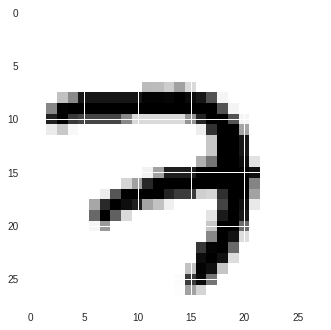

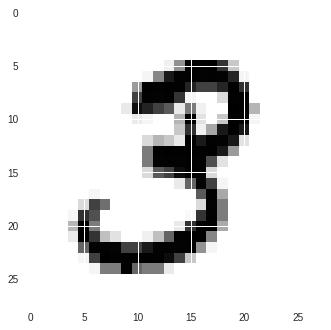

In [4]:
for i in range(2):
  image = train_data[i]
  image = image.reshape((28, 28))
  plt.imshow(image)
  plt.show()


In [0]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [0]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions={"pred_class":pred_classes,'pred_probas':pred_probas}) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [7]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpzl6kwcy5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f28fe574cf8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipeline

In [9]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-16T23:30:52Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmpzl6kwcy5/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-16-23:30:57
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9883, global_step = 2000, loss = 0.041659594
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpzl6kwcy5/model.ckpt-2000


{'accuracy': 0.9883, 'global_step': 2000, 'loss': 0.041659594}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpzl6kwcy5/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


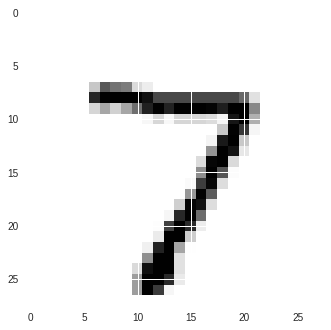

Model prediction: 7
Probablities: [1.9246182e-12 3.8034211e-12 2.1311701e-09 8.4298737e-09 1.0620493e-14
 6.7582784e-12 2.3434339e-20 1.0000000e+00 5.3772736e-13 1.6984325e-10]


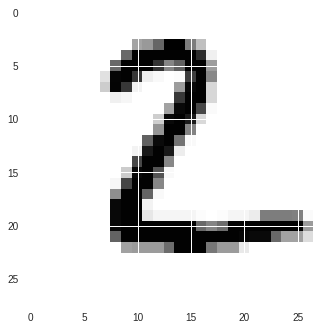

Model prediction: 2
Probablities: [1.0481496e-10 3.6301987e-08 1.0000000e+00 2.8516982e-11 1.9143625e-13
 4.1962980e-18 2.1781552e-12 6.2877134e-13 1.1209900e-11 2.6414621e-15]


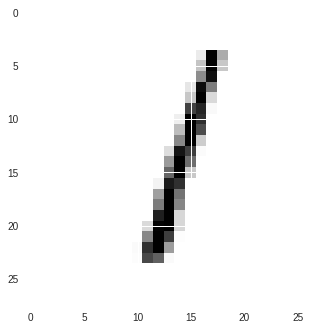

Model prediction: 1
Probablities: [8.64789840e-08 9.99765813e-01 2.41795101e-06 1.12293364e-07
 1.72378190e-04 1.45714694e-06 3.51259973e-06 4.27155319e-05
 1.11008821e-05 4.04787926e-07]


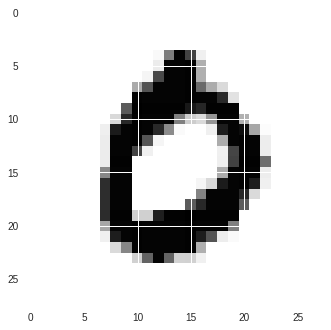

Model prediction: 0
Probablities: [9.9999595e-01 7.0370804e-10 9.5981102e-07 8.6537799e-09 2.0165486e-11
 5.7895687e-07 5.9046556e-08 2.0226483e-07 1.3307660e-08 2.1536721e-06]


In [10]:
# Predict single images
n_images = 4
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds =list(model.predict(input_fn))

for i in range(len(preds)):
  plt.imshow(np.reshape(test_images[i], [28, 28]))
  plt.show()
  print("Model prediction:",preds[i]['pred_class'])
  print("Probablities:",preds[i]['pred_probas'])


#### Effect Of Temperature on Softmax Function

In [0]:
# Define a manual softmax function
def softmax(x):
  return np.exp(x)/(np.exp(x).sum())

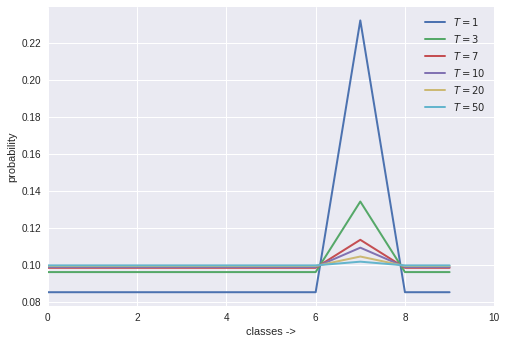

In [12]:
image_prob=preds[0]['pred_probas']
temperature = [1,3,7,10,20,50]

for temp in temperature:
  plt.plot((softmax(image_prob/temp)), label='$T='+str(temp)+'$', linewidth=2)
  plt.legend()
plt.xlabel('classes ->')
plt.ylabel('probability')
plt.xlim([0, 10])
plt.show()

In [46]:
# Prepare the input train data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': train_data}, shuffle=False)
# Use the model to predict the images class
preds =list(model.predict(input_fn))

input_eval_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': eval_data}, shuffle=False)
# Use the model to predict the images class
preds =list(model.predict(input_fn))
preds_eval =list(model.predict(input_eval_fn))
predictions_prob=[]
predictions_eval_prob=[]
for i in range(len(preds)):
  predictions_prob.append(preds[i]['pred_probas'])
for j in range(len(preds_eval)):
  predictions_eval_prob.append(preds_eval[j]['pred_probas'])
  


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpzl6kwcy5/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpzl6kwcy5/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpzl6kwcy5/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [131]:
# Perform a manual softmax at raised temperature
train_logits_T = np.array(predictions_prob)/7
eval_logits_T = np.array(predictions_eval_prob)/7

Y_train_soft = softmax(train_logits_T)
Y_eval_soft = softmax(eval_logits_T)
Y_train = np_utils.to_categorical(train_labels, 10)
Y_Test = np_utils.to_categorical(eval_labels, 10)
# Concatenate so that this becomes a 10 + 10 dimensional vector
Y_train_new = np.concatenate([Y_train, Y_train_soft], axis=1)
print (Y_Test.shape)
print (Y_eval_soft.shape)
Y_test_new = np.concatenate([Y_Test, Y_eval_soft], axis=1)

(10000, 10)
(10000, 10)


In [132]:
print (Y_train_new[0])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
 1.7907042e-06 1.7907042e-06 1.7907382e-06 1.7962770e-06 1.7907042e-06
 1.7907042e-06 1.7907042e-06 2.0592399e-06 1.7907042e-06 1.7907096e-06]


In [156]:
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.layers import Activation,Dense, Flatten, concatenate, Lambda
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy
from keras.models import Model
# This is a standalone student model (same number of layers as original student model) trained on same data
# for comparing it with teacher trained student.

n_student = Sequential()
n_student.add(Flatten(input_shape=(28, 28, 1)))
n_student.add(Dense(32, activation='relu'))
n_student.add(Dropout(0.2))
n_student.add(Dense(10))
n_student.add(Activation('softmax'))

n_student.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
n_student.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_39 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 32)                25120     
_________________________________________________________________
dropout_39 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 10)                330       
_________________________________________________________________
activation_57 (Activation)   (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [157]:
print (train_data.shape)
print (eval_data.shape)

# Reshape them to batch_size, width,height,#channels
X_train = train_data.reshape(55000, 28, 28, 1)
X_test = eval_data.reshape(10000, 28, 28, 1)
n_student.fit(X_train, Y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(X_test, Y_test))

(55000, 784)
(10000, 784)
Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 4s 64us/step - loss: 0.8610 - acc: 0.7455 - val_loss: 0.3641 - val_acc: 0.9029
Epoch 2/5
55000/55000 [==============================] - 1s 16us/step - loss: 0.4274 - acc: 0.8742 - val_loss: 0.2799 - val_acc: 0.9205
Epoch 3/5
55000/55000 [==============================] - 1s 16us/step - loss: 0.3547 - acc: 0.8956 - val_loss: 0.2447 - val_acc: 0.9273
Epoch 4/5
55000/55000 [==============================] - 1s 16us/step - loss: 0.3214 - acc: 0.9053 - val_loss: 0.2241 - val_acc: 0.9344
Epoch 5/5
55000/55000 [==============================] - 1s 17us/step - loss: 0.2945 - acc: 0.9139 - val_loss: 0.2066 - val_acc: 0.9394


In [160]:
z=(n_student.predict(X_test))
labels=[]

for pred in z:
  labels.append(np.argmax(pred))
  
print (np.sum(np.equal(eval_labels, labels))/100)

93.94


In [150]:
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model

student = Sequential()
student.add(Flatten(input_shape=(28, 28, 1)))
student.add(Dense(32, activation='relu'))
student.add(Dropout(0.2))
student.add(Dense(10))
logits=student.layers[-1].output
# This is going to be a tensor. And hence it needs to pass through a Activation layer
probs = Activation('softmax')(logits)

# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / 5)(logits)
probs_T = Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])
student = Model(student.input, output)
student.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flatten_38_input (InputLayer)   (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_38 (Flatten)            (None, 784)          0           flatten_38_input[0][0]           
__________________________________________________________________________________________________
dense_74 (Dense)                (None, 32)           25120       flatten_38[0][0]                 
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 32)           0           dense_74[0][0]                   
__________________________________________________________________________________________________
dense_75 (

In [0]:
# This will be a teacher trained student model. 
# --> This uses a knowledge distillation loss function

# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :10], y_true[: , 10:]
    
    y_pred, y_pred_softs = y_pred[: , :10], y_pred[: , 10:]
    
    loss = alpha*logloss(y_true,y_pred) + logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :10]
    y_pred = y_pred[:, :10]
    return categorical_accuracy(y_true, y_pred)

student.compile(
    optimizer='adam',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.2),
    metrics=[acc] )

In [162]:
student.fit(X_train, Y_train_new,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(X_test,Y_test_new))

Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 4s 71us/step - loss: 0.0416 - acc: 0.9375 - val_loss: 0.0301 - val_acc: 0.9565
Epoch 2/5
55000/55000 [==============================] - 1s 18us/step - loss: 0.0403 - acc: 0.9395 - val_loss: 0.0296 - val_acc: 0.9562
Epoch 3/5
55000/55000 [==============================] - 1s 18us/step - loss: 0.0387 - acc: 0.9416 - val_loss: 0.0293 - val_acc: 0.9563
Epoch 4/5
55000/55000 [==============================] - 1s 18us/step - loss: 0.0379 - acc: 0.9417 - val_loss: 0.0280 - val_acc: 0.9589
Epoch 5/5
55000/55000 [==============================] - 1s 18us/step - loss: 0.0369 - acc: 0.9434 - val_loss: 0.0278 - val_acc: 0.9593


In [163]:
z=(student.predict(X_test))
labels=[]

for pred in z:
  labels.append(np.argmax(pred))
  
print (np.sum(np.equal(eval_labels, labels))/100)

95.93
